In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils import *
from utils_ecoli import *
from GSMM import *
from models_MWCq import *
check_device()
print(models_)

img_outs = os.path.abspath('../images/ecoli')

CUDA is not available.
+--------------+-----------------------+
| ORGANISM     | MODEL_SBML            |
+==============+=======================+
| ECOLI_core   | e_coli_core_SBML3.xml |
+--------------+-----------------------+
| mus_musculus | mus_iMM1415.xml       |
+--------------+-----------------------+
| homo_sapiens | Recon3D.xml           |
+--------------+-----------------------+


In [3]:
# load metadata
data_path = os.path.abspath('../data/e_coli_data/original/')
metadata = pd.read_csv(os.path.join(data_path, 'metadata.csv'), index_col = 0)
metadata.drop(metadata.index[236:240], axis=0, inplace = True)

# load augmented data and prepross feat 
# see '../data/e_coli_data/data/e_coli_data/augmented/preprocessing.ipynb' for preprocessing
data_path = os.path.abspath('./../data/e_coli_data/augmented')
data_dict = pk_load(os.path.join(data_path, 'aug_data_dict.pk'))
data = list(data_dict.values())[0]
R = list(data_dict.values())[1]
srm = list(data_dict.values())[2]

combined_outs = pk_load(os.path.join(data_path, 'combined_outs.pk'))
bounds = combined_outs['bounds'] # reaction bounds for FBA
mw_nodes = combined_outs['mw_nodes'] # ground truth max weighted clique nodes
gt_clique_obj = combined_outs['gt_clique_obj'] # obj function formulated from gt max weighted clique (gt_mwcq)
RES_b = combined_outs['RES_b'] # FBA solutions using biomass function
RES_c = combined_outs['RES_c'] # FBA solutions using gt_mwcq

n_samples = data.shape[1]

loading e_coli_core_SBML3.xml...
137 genes
72 metabolites
95 reactions with bound max 1000


,count,mean,std,min,25%,50%,75%,max
0,95.0,22.21,17.8,1.0,3.5,18.0,40.0,58.0


graph with 95 nodes, 1055 edges
is directed: False
is connected: False connected subgraphs: 2
has self loops: False


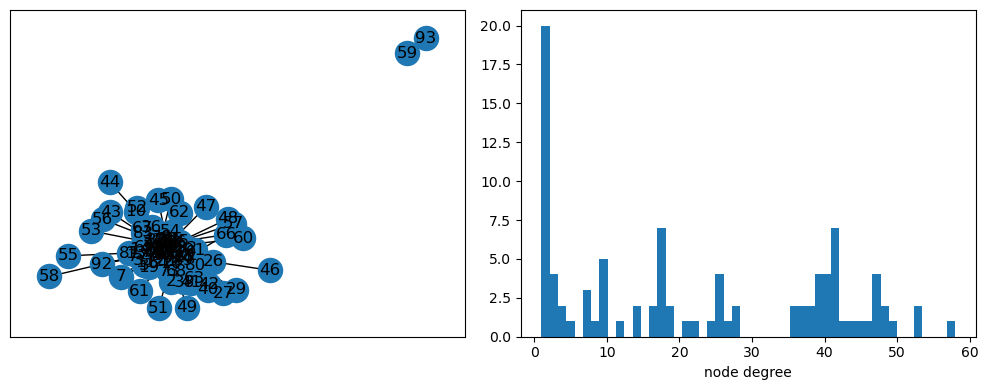

In [4]:
# load model
models_dir = os.path.abspath('../src/sbml_models/')
organism = "ECOLI_core"
sbml_file = libsbml.readSBMLFromFile(os.path.join(models_dir, models[organism]))

gene_exp_scale = 10
bound_max = 1000
model = metabolic_model(organism, sbml_file, bound_max=bound_max)
m_model = model


# calculate stoichiometric matrix S and metabolic graph G
S = model.S
S_matrix = model.S_matrix
reactions = list(model.reactions.keys())
metabolites = list(model.metabolites.keys())

S_bool = np.array(S_matrix.astype('bool').astype('int'))
RAG = np.matmul(S_bool.T, S_bool)
adj = RAG.astype('bool').astype('int') 
adj = adj - np.identity(adj.shape[0]) #remove self loops ##symmetric boolean adj matrix
A = sp.csr_matrix(adj)
G = nx.from_scipy_sparse_array(A)

degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
fig, axes = plt.subplots(1,2, figsize = (10,4))
ax = axes[0]
nx.draw_networkx(G, ax = ax)
ax = axes[1]
ax.hist(degrees, bins=50)
ax.set_xlabel("node degree")
fig.tight_layout()


print(f'graph with {len(G.nodes)} nodes, {len(G.edges)} edges')
print(f'is directed: {G.is_directed()}')
print(f'is connected: {nx.is_connected(G)}', 
      f'connected subgraphs: {len([G.subgraph(c).copy() for c in nx.connected_components(G)])}')
print(f'has self loops: {any(G.has_edge(node, node) for node in G.nodes)}')

## Max Wt Clique Prediction

In [5]:
# calculate input features for metabolic graph and mapped reactions
graph = base_graph(G, m_model)
graph.get_input_features(srm, R) 

/Users/hollysteach/Documents/GitHub/metabolic_GNN/src/utils.py:58: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391829313/work/torch/csrc/utils/tensor_new.cpp:607.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [6]:
# initialize data
total_samples = len(graph.f)
psd_features = []
sctdataset = []

for s in range(total_samples):
    feat = graph.f[s]
    data = Data(x=np.array(feat),edge_index=graph.edge_index)
    psd_features += (data.x.tolist())
    sctdataset += [data]

num_trainpoints = int(np.floor(0.6*total_samples))
num_valpoints = int(np.floor(num_trainpoints/3))
num_testpoints = total_samples - (num_trainpoints + num_valpoints)
traindata= sctdataset[0:num_trainpoints]
valdata = sctdataset[num_trainpoints:num_trainpoints + num_valpoints]
testdata = sctdataset[num_trainpoints + num_valpoints:]
print(len(traindata))
print(len(valdata))
print(len(testdata))

batch_size = 80

def my_collate(batch):
    data = [item for item in batch]
    return data
train_loader = DataLoader(traindata, batch_size, shuffle=True,collate_fn=my_collate)
test_loader = DataLoader(testdata, batch_size, shuffle=False,collate_fn=my_collate)
val_loader =  DataLoader(valdata, batch_size, shuffle=False,collate_fn=my_collate)

1808
602
604


In [7]:
'''
model params
--------------------------------------------------------------------------------
'''

order = 3
N = 95
penalty_coefficient = 0.2
lr = 1e-4
wt_decay = 0
EPOCHS = 4


def run_model():
    torch.manual_seed(1)

    '''
    init
    --------------------------------------------------------------------------------
    '''
    model = scattering_GNN(graph,
                    input_dim =4, 
                hidden_dim=8, 
                output_dim=1, 
                n_layers=3)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=wt_decay) 
    
    '''
    train
    --------------------------------------------------------------------------------
    '''


    # EPOCHS = 5

    #progress
    fig, axes = plt.subplots(1, (EPOCHS+1), figsize = ((EPOCHS+1)*4,4))
    td = [[i,batch] for i, batch in enumerate(train_loader)]
    batch = td[0][1]
    plot_support(model, batch, ax=axes[0])
    axes[0].set_title(f'input')

    for i in range(EPOCHS):
        train(model, i, train_loader, optimizer, penalty_coefficient, verbose=False)
        
        td = [[i, batch] for i, batch in enumerate(train_loader)]
        batch = td[0][1]
        
        # Pass the subplot axes as an argument to the plot_support function
        plot_support(model, batch, ax=axes[i + 1])
        axes[i + 1].set_title(f'Epoch {i + 1}')



    '''
    model eval
    --------------------------------------------------------------------------------
    '''
    model.eval()
    mwc_res = []
    for d in sctdataset:
        features = torch.FloatTensor(d.x)
        output_dis = model(features)
        outs = output_dis.detach().numpy().reshape(-1,)
        mwc_res += [outs]



    res = pd.DataFrame(mwc_res)
    res.index = srm.index
    res.columns = srm.columns

    return res, fig


init model; total number of parameters: 793
Epoch:-----0
Epoch:-----1
Epoch:-----2
Epoch:-----3
Epoch:-----4


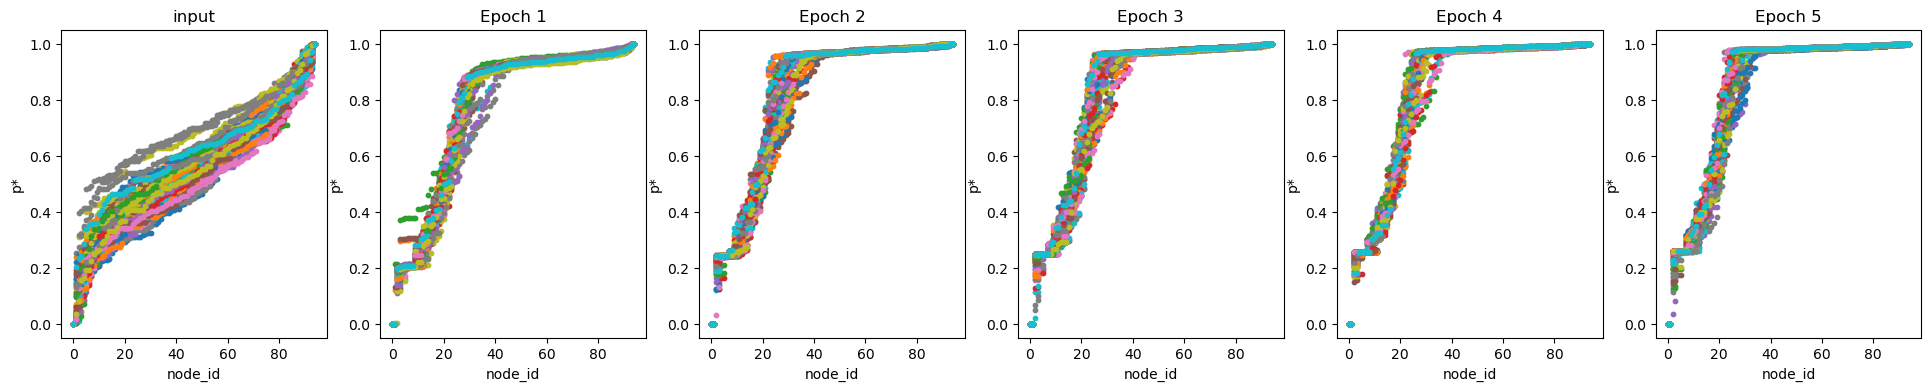

In [112]:
'''
model params
--------------------------------------------------------------------------------
order: (int) order of scattering features in each layer (J)
penalty_coefficient: weight for L2 component of loss function
N = number of nodes in metabolic graph
'''

order = 3
penalty_coefficient = 0.25
N = 95
lr = 2e-4
wt_decay = 0
EPOCHS = 5

res, fig = run_model()
img_outs = os.path.abspath('../images/ecoli')
fig.savefig(os.path.join(img_outs, 'ecoli_mwc_training.pdf'), dpi= 300)

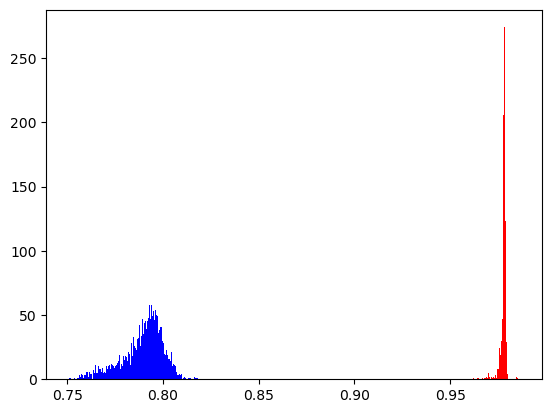

In [113]:
# compare probabilities to ground truth clique
clique_p = []
inv_p = []

for sample in range(total_samples):
    p = res.iloc[sample,:].to_numpy()
    gt_clique = [1 if i in mw_nodes[sample] else 0 for i in range(95)]
    inv_clique = [~x & 1 for x in gt_clique]

    clique_p += [np.sum(gt_clique*p)/np.sum(gt_clique)]
    inv_p += [np.sum(inv_clique*p)/np.sum(inv_clique)]

plt.hist(clique_p, bins = 200, color = 'red')
plt.hist(inv_p, bins = 200, color='blue')

plt.savefig(os.path.join(img_outs, 'mwc_pred_v_gt.pdf'), dpi= 300)
plt.show()



/Users/hollysteach/anaconda3/envs/met_env_sc/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


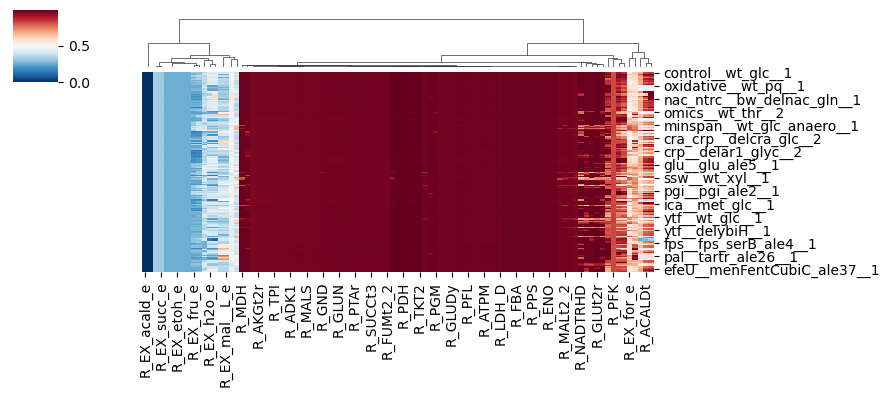

In [117]:
# visualize and save predicted probabilities
res.to_csv(os.path.join(data_path, 'augmented_probabilieis.csv'))

# subset to original data
p_support = res.iloc[:274,:]



sns.clustermap(p_support, row_cluster= False, cmap= 'RdBu_r', figsize = (9,4))
plt.show()

In [119]:
# FBA gt
from scipy.optimize import linprog

RES_p = []
failed = []

for sample in range(len(bounds)):
    b = bounds[sample]
    c = res.iloc[sample, :].to_numpy()
    r = linprog(c,A_ub=None, b_ub=None, A_eq = S_matrix, b_eq = np.zeros(S_matrix.shape[0]),
                            bounds=b)
    if r.success:
        RES_p.append(r)
    else:
        print(f'failed: {sample}')
        failed += [sample]

failed: 983
failed: 1532
failed: 1806
failed: 2080
failed: 2085
failed: 2359
failed: 2628


In [120]:
'''
comparisons
**we subset to the original 274 experimental samples
----------------

RES_p: FBA solutions using predicted mwcq likelihoods (p)
RES_b: FBA solutions using biomass function
RES_c: FBA solutions using gt_mwcq

bounds: FBA reaction bounds
mw_nodes: gt mwcq
'''


# solutions for each comparison
p_solutions = [x.x for x in RES_p][:274]
b_solutions = [x.x for x in RES_b][:274]
c_solutions = [x.x for x in RES_c][:274]

# max c values for each comparison
p_fun = [x.fun for x in RES_p][:274]
b_fun = [x.fun for x in RES_b][:274]
c_fun = [x.fun for x in RES_c][:274]

c_size = [len(mw_nodes[i]) for i in range(274)]
p_size = [np.sum(p_support.iloc[i,:]) for i in range(274)]



In [121]:
import pygraphviz as pgv
import networkx as nx
import matplotlib.pyplot as plt
cmap = sns.color_palette("flare", as_cmap=True)

G = graph.G
g = min(nx.connected_components(graph.G), key= len)
G_sub = max(nx.connected_components(graph.G), key= len)

pos = nx.spring_layout(G, seed= 1969)

#adjust disconnected node position

pos[59] = np.array([-0.23, 0.23])
pos[93] = np.array([-0.21, 0.21])

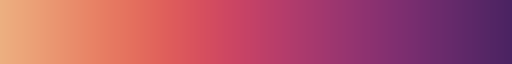

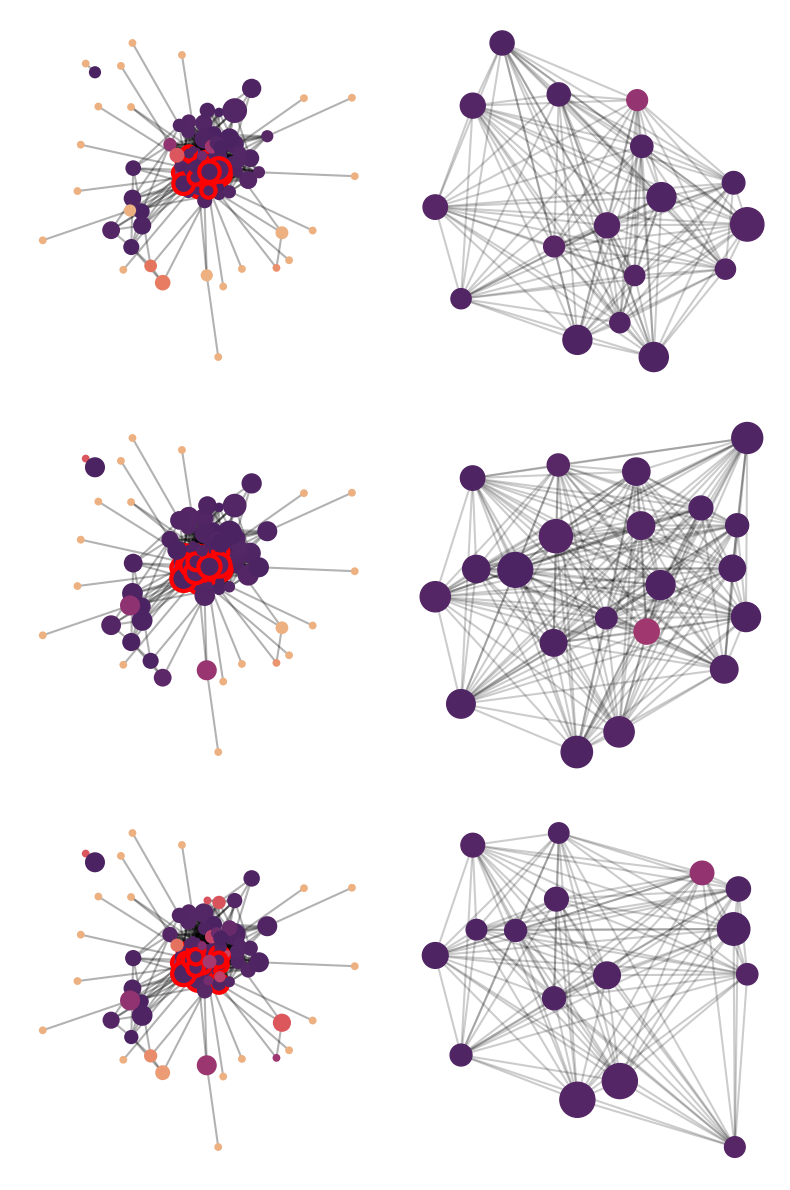

In [122]:
study = 'ssw'

if study == 'ica':
    t1 = list(res.index).index('ica__tyr_glcn__1') #0.57
    t2 = list(res.index).index('ica__no3_anaero__1') # 0.35
    t3 = list(res.index).index('ica__ura_pyr__1') # #0.27

if study == 'ssw':
    t1 = list(res.index).index('ssw__wt_ac__1') #
    t2 = list(res.index).index('ssw__wt_glc__1') #
    t3 = list(res.index).index('ssw__wt_xyl__1') #



fig, axes = plt.subplots(3,2, figsize = (8, 12))
cmap = sns.color_palette("flare", as_cmap=True)


for i, sample in enumerate([t1,t2,t3]): 
    ax1 = i*2
    ax2 = ax1+1
    ##
    ax = axes.flatten()[ax1]
    # c=srm.iloc[sample,:]
    c=res.iloc[sample,:]
    gexp = np.sqrt(graph.srm.iloc[sample,:]+0.1)
    nodes_sub = mw_nodes[sample]
    edge_colors = ['red' if i in nodes_sub else 'white' for i in range(len(G.nodes))]
    color_list = [(1, 0, 0, 1) if i in nodes_sub else (0, 0, 0, 0) for i in range(len(G.nodes))]

    nx.draw_networkx_edges(G, pos= pos, ax = ax, 
                       alpha = 0.3, 
                       width= 1.5)
    nx.draw_networkx_nodes(G, pos= pos, ax = ax,
                        node_color= c, 
                        cmap = cmap, 
                        vmin=0.5, vmax=1,
                        node_size = gexp*100, 
                        edgecolors = color_list, 
                        linewidths= 3)

    ##
    ax = axes.flatten()[ax2]
    nodes_sub = mw_nodes[sample]
    g = G.subgraph(nodes_sub)

    c_sub = c[nodes_sub]
    gexp_sub = gexp[nodes_sub]

    nx.draw_networkx_edges(g, pos= pos, ax = ax, 
                        alpha = 0.2, 
                        width= 1.5)
    nx.draw_networkx_nodes(g, ax = ax,
                        pos= pos, 
                        node_color= c_sub, 
                        vmin=0.5, vmax=1,
                        cmap = cmap, 
                        node_size = gexp_sub*200)
    # nx.draw_networkx(g, ax = ax, pos = pos, node_color= c_sub, cmap= cmap)

    

for ax in axes.flatten():
    ax.set_axis_off()
fig.tight_layout()

if study == 'ica':
    plt.savefig(os.path.join(img_outs, 'ecoli_graph_vis_ica.pdf'), dpi= 300)
if study == 'ssw':
    plt.savefig(os.path.join(img_outs, 'ecoli_graph_vis_ssw.pdf'), dpi= 300)

cmap

# -----------------------------------------
supplemental experiments
# -----------------------------------------

In [123]:
# interpret results by available carbon source
carbon = pd.DataFrame(metadata['Carbon Source (g/L)']).rename(columns = {'Carbon Source (g/L)': 'carbon_source'})
carbon = pd.concat(carbon for i in range(11)).set_index(res.index)
carbon = pd.merge(carbon, res, left_index=True, right_index=True, how= 'left')